# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Overview

Starbucks Corporation is an American multinational chain of coffeehouses and roastery reserves headquartered in Seattle, Washington.
Like many other other companies, Starbucks has offers of various types.
They give offers depending on demographics, so not all customers receive those offers, again depending on their demographics.
In this notebook, I am going to take through analysis that I have done about the startbuck datasets.
Most importantly, I will perform a machine learning algorithm to help predict the offer type given for a client

# Problem statement

The goal of this project if to predict the amount that a customers will spend, depending on the demographics and the orders.
	1.	Clean the data
	2.	Create a classifier
	3.	Evaluate the model
	4.	Improve the model using an other algorithm
	5.	Re-evaluate the model

The final algorithm should be able to make accurate prediction about the type of offer that a client should receive.

# Metrics 

The most common metric that is used in classification models is the **ACCURACY** and that is what we are going to use to evaluate our model.

Accuracy works fine in this case because we have a quite balance datasets for the three classes we are predicting for.
For instance if we had a model with two classes A and B and A represent 92% of the dataset and B 8%, computing the model's accuracy would easily give us an accuracy around 92%.
In those cases we could have used other methods like Logarithmic Loss confusion matrix.

# Data Exploration

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [20]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline

In [21]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [22]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37a657e7f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f37a655a208>]], dtype=object)

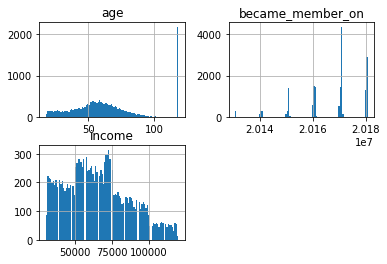

In [23]:
profile.describe()
profile.hist(bins = 100)

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37a64b3320>]], dtype=object)

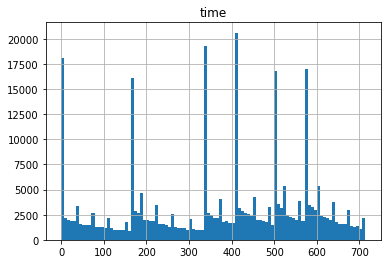

In [26]:
transcript.hist(bins = 100)

In [27]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37a63752e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f37a62bbda0>]], dtype=object)

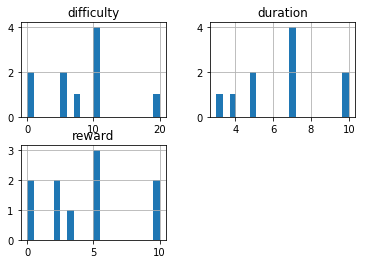

In [28]:
portfolio.hist(bins = 20)

In [29]:
# Finding the number of unique clients in this data set
print(len(profile['id'].unique()))

17000


In [30]:
# Finding the unique offers in the data set
print(len(portfolio['id'].unique()))

10


In [31]:
# average difficulty to complete an offer
portfolio['difficulty'].mean()

7.7000000000000002

In [32]:
# average rewards for offers
portfolio['reward'].mean()

4.2000000000000002

In [33]:
# Unique events
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [34]:
# Unique offer type in the data set
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [35]:
# Average duration for the offers
portfolio['duration'].mean()

6.5

# Exploratory visualizations

Below are visuals that can help us better understand this dataset

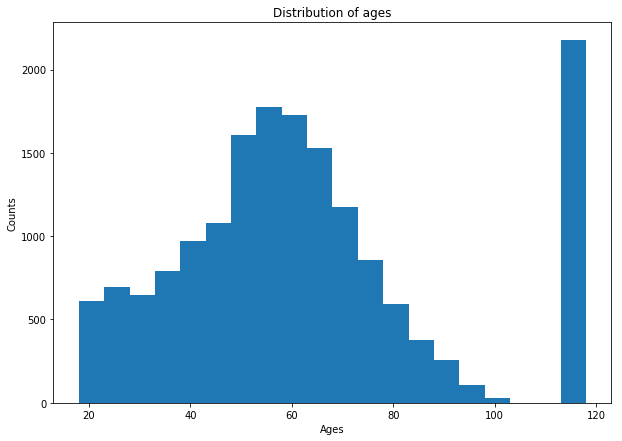

In [36]:
# Distribution of the ages
# Creating histogram 
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(profile['age'], bins = 20) 
  
# Show plot 
plt.xlabel('Ages')
plt.ylabel('Counts')
plt.title('Distribution of ages')
plt.show()

In [37]:
transcript.shape[0]

306534

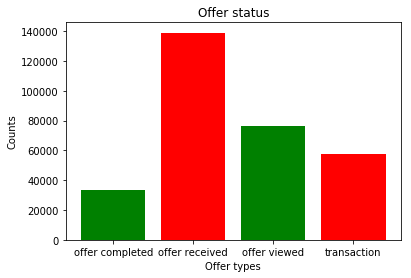

In [38]:
# visualize count per event
x_label = transcript['event'].unique()
y_label = transcript['event'].value_counts().values

# plotting a bar chart 
plt.bar(x_label, y_label, width = 0.8, color = ['red', 'green']) 
  
# naming the x-axis 
plt.xlabel('Offer types') 
# naming the y-axis 
plt.ylabel('Counts') 
# plot title 
plt.title('Offer status') 
  
# function to show the plot 
plt.show() 

In [39]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

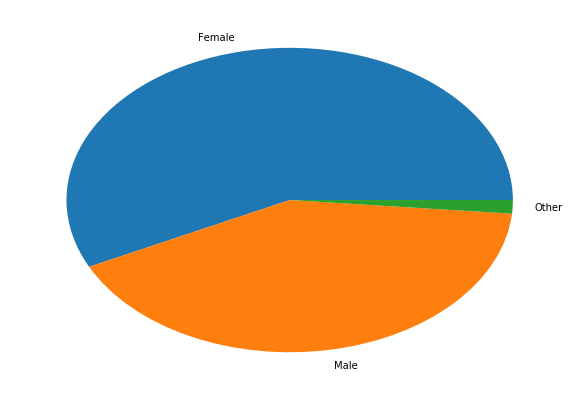

In [40]:
# Visualize gender repartition
# Creating plot 
labels = ['Female', 'Male', 'Other']
data = profile['gender'].value_counts().values
fig = plt.figure(figsize =(10, 7)) 
plt.pie(data, labels = labels) 
  
# show plot 
plt.show() 

# Data Preprocessing

The below function helps us put together a dataframe that we will use for the training and testing our datasets.
We have three datasets and we want to combine them into one.
This is what we want the final dataframe to look like:

Event, Time, Offer_id, Amount, Reward, Age_group, Gender,Income

In [41]:
profile.head(1)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN


In [42]:
portfolio.head(1)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


In [43]:
transcript.head(1)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


In [44]:
transcript['value'].unique

<bound method Series.unique of 0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16       

We want to be able to contruct a dataframe that has all the listed columns to be to train.
The transcript dataframe will be the main the start.
The dataframe has offer_id marked as values, and we first want to be able to extract those from the value column

In [45]:
# Extracting offer_id from the transcript df
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [46]:
transcript.head()

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [47]:
# We then drop the values column since we don't need it anymore
transcript = transcript.drop(['value'] , axis =1)
transcript.head()


,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [48]:
# Now that we have the id, let's get the offer type
def extract_offer_type(offer_id):
    '''
    offer_id : the offer id you want to find the type for
    
    '''
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: extract_offer_type(x['offer_id']), axis=1)

There above, we said that we wanted to have an age group column, which does not exist, so let create it

In [49]:
# Creating the age group group column
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['children', 'infant', 'Teens', 'adults', 'elderly'])
# dropping the age columns
profile = profile.drop(['age'], axis = 1)

In [50]:
profile.head()

,became_member_on,gender,id,income,age_groups
0,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,elderly
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,adults
2,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,elderly
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,elderly
4,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,elderly


Now that we have our dataframe almost ready, let's start combinining them to create the final dataframe

In [51]:
# We are predicting for the pffer type so we do not want row that do not have the offer_id
transcript = transcript[transcript['offer_id'] != 'NA']

In [52]:
def add_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: add_gender(x['person']), axis=1)

In [53]:
def add_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: add_income(x['person']), axis=1)

In [54]:
def add_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: add_age_group(x['person']), axis=1)

In [55]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,gender,income,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,F,100000.0,elderly
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,None,NaN,elderly
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,M,70000.0,elderly
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,None,NaN,elderly
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,None,NaN,elderly


In [56]:
#Let's now transform our features into classes
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

# Now let tranform the target which is the offer type col
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'Teens': 1, 'adults': 2, 'elderly': 3, 'infant': 4}}
{'gender': {'F': 1, 'M': 2, 'O': 3}}
{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [57]:
# For all the features transformed up there, we will turn them into numerical values
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)

transcript.replace(replace_map_comp_offer_type, inplace=True)

In [58]:
# Here are the X and Y that we want to use to predict
y = transcript['offer_type']
X = transcript.drop(['person', 'offer_type'], axis = 1)

In [59]:
X['gender'].fillna(X['gender'].mode()[0], inplace=True)

In [60]:
X['income'].fillna(X['income'].mean(), inplace=True)
X.head()

,event,time,offer_id,amount,reward,gender,income,age_group
0,2,0,8,0,0,1.0,100000.000000,3
1,2,0,2,0,0,2.0,64337.000755,3
2,2,0,4,0,0,2.0,70000.000000,3
3,2,0,11,0,0,2.0,64337.000755,3
4,2,0,6,0,0,2.0,64337.000755,3


In [61]:
sum(X['gender'].isnull())

0

Before we train , it is important that we scale some of the columns
The following cell does that

In [62]:
scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']
X[to_normalize] = scaler.fit_transform(X[to_normalize])

In [63]:
X

,event,time,offer_id,amount,reward,gender,income,age_group
0,2,0.0,8,0.000000,0.0,1.0,0.777778,3
1,2,0.0,2,0.000000,0.0,2.0,0.381522,3
2,2,0.0,4,0.000000,0.0,2.0,0.444444,3
3,2,0.0,11,0.000000,0.0,2.0,0.381522,3
4,2,0.0,6,0.000000,0.0,2.0,0.381522,3
5,2,0.0,10,0.000000,0.0,2.0,0.255556,3
6,2,0.0,3,0.000000,0.0,2.0,0.381522,3
7,2,0.0,5,0.000000,0.0,2.0,0.233333,2
8,2,0.0,2,0.000000,0.0,1.0,0.300000,2
9,2,0.0,2,0.000000,0.0,1.0,0.455556,2


# Implementation / refinement
In this part we will start with a radom forest classifier

In [64]:
# Let's split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [65]:
# Implementing Random forest
Rand_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
Rand_model.fit(X_train, y_train)

y_pred_rand = Rand_model.predict(X_test)

In [66]:
# Let's now try a linear regression model 
Linear_model = LogisticRegression()

Linear_model.fit(X_train, y_train)

y_Linear_model = Linear_model.predict(X_test)

In [67]:
# Last we will try a decision tree model

Decision_model = DecisionTreeClassifier()
Decision_model.fit(X_train, y_train)

y_Decision_model = Decision_model.predict(X_test)

# Evaluating the model

In [68]:
len(y_Decision_model)

76634

In [69]:
# reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

In [70]:
# SIde by side comparison
models = [Decision_model, Rand_model, Linear_model]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [71]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,DecisionTreeClassifier,RandomForestRegressor,LogisticRegression
Training Accuracy,100.0,100.0,80.527621
Predicting Accuracy,100.0,100.0,92.820000


# Model Improvement

In [ ]:
# improving the model takes too long to run, you will need around 3 hours to run the improvment depending on your pc's performances

In [73]:
# Let's tune our linear regression model to see it we get better results
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
dual = [True, False]
parameters = dict(dual = dual, max_iter = max_iter, C = C)

imp_model = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = imp_model, param_grid = parameters, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.8231970421922575
Best params: {'C': 3.5, 'dual': True, 'max_iter': 100}


# Model Validation + Justification

From the above result, we can see that all the model predict good, the DecisionTreeClassifier and the RandomForestRegressor both predict 100% accurate on the train and the test data set, while in the other hand, the Logistic regression predicts 80 for the train and 92 for the test.
Taking one of the two models that predict 100% might lead us to overfitting, so to avoid that we are going to keep the Logistic regression, because event if it is predicting 100% accurate, the accuracy is still good and we can avoid overfitting

# Reflection

On the most important and I would say interresting part of the project was cleaning the data for the training.
We had three different datasets that we wanted to combine and that was difficult but interesting.
Also I playing around with different algoriths was fun.
I could see how great certain algorithms are doing, and also how bad some other were doing.

I finaly chose to go with the regression algorith, given that we wanted to avoid overfitting.
We can as well improve this algorithm by using gridsearch.
Given that gridsearch is great at finding the perfect parameters, we would probabibly have better result since this regression algorithm is using default parameters.

# Conlusion

We wanted from the begining the create a machine learning model that can well predict the offer to be given to a customer, given its demographics.
and we were able to do so.
The advantage of this that we are able to predict, what should be given to a customer, therefore increase the chances of having a customer react to an offer.

What type of offer would you like to receive?